In [ ]:
# without masking and weighting 10% div on 2 parts

In [1]:
import re
import nltk
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.sparse as sp
import pandas as pd
import tokenize

from io import StringIO 
from nltk.tokenize import word_tokenize
from tqdm.notebook import tqdm
from os import listdir
from os.path import isfile, join
from rouge_score import rouge_scorer
from rouge import Rouge 

rouge = Rouge()

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'])

In [2]:
val_preproc_dir = r"C:\Users\RedmiBook\Documents\SCE\proj\datasets\2021val_annual_reports_prepr-20220901T133401Z-001\2021val_annual_reports_prepr"
name_of_files = [f for f in listdir(val_preproc_dir) 
             if isfile(join(val_preproc_dir, f))]
list_of_files = []
for file_name in name_of_files:
    list_of_files.append(open(val_preproc_dir + "\\" + file_name, "r").read())

In [3]:
half_perc, perc = 0.05, 0.10
list_of_files_1 = [file[:int(len(file) * half_perc)] for file in list_of_files] 
list_of_files_2 = [file[int(len(file) * half_perc):int(len(file) * perc)] for file in list_of_files]

In [4]:
def token(txt_splited):
    res_finish = []
    for text in tqdm(txt_splited):
        res_txt = []
        for paragraph in text:
            res_par = ''
            for token in tokenize.generate_tokens(StringIO(paragraph).readline):
                if token.type == 1:
                    res_par += token.string.lower() + ' '
            res_txt.append(res_par)
        res_finish.append(res_txt)
        
    return res_finish

In [5]:
txt_splited_1, txt_splited_2 = [file_txt.split('\n') for file_txt in list_of_files_1], [file_txt.split('\n') for file_txt in list_of_files_2]
txt_str_div_par_1, txt_str_div_par_2 = token(txt_splited_1), token(txt_splited_2)

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/363 [00:00<?, ?it/s]

In [6]:
def make_vocab(txt_str_div_par):
    txt_str = txt_str_div_par.copy()
    for i, txt in enumerate(txt_str_div_par):
        txt_str[i] = ''.join(txt)

    vocab_list = []
    for i, txt in enumerate(txt_str):
        vocab = list(re.split(' \n| ', txt))

        if '' in set(vocab):
            vocab.remove("")
        vocab_list.append(list(set(vocab)))
    return vocab_list, txt_str

In [7]:
vocab_list_1, txt_str_1 = make_vocab(txt_str_div_par_1)
vocab_list_2, txt_str_2 = make_vocab(txt_str_div_par_2)

In [10]:
def list_of_words_max_len(txt_str):
    list_of_words = [txt.split(' ') for txt in txt_str]
    for i in range(len(list_of_words)):
        list_of_words[i] = [w for w in list_of_words[i] if w]

    len_words = [len(v) for v in list_of_words]
    max_len_words = max(len_words)
    return list_of_words, len_words, max_len_words

In [11]:
list_of_words_1, len_words_1, max_len_words_1 = list_of_words_max_len(txt_str_1)
list_of_words_2, len_words_2, max_len_words_2 = list_of_words_max_len(txt_str_2)

In [11]:
def sparse_triangle_max(max_len_words, sig=25):    
    S = sp.dok_array((max_len_words + 2 * sig, max_len_words + 2 * sig), dtype=np.float32)
    res_f = [(1 - np.abs(i - sig) / sig) for i in range(1, sig * 2)]
    for i in tqdm(range(sig, sig + max_len_words), total=max_len_words):
        S[i, i-sig+1:i+sig] = res_f
    return S

In [12]:
def sparse_triangle_crop(S, size, sig=25):
    return S[sig:sig + size, sig:sig + size]

In [13]:
def sparse_vocab(text, vocab):    
    S = sp.dok_array((len(vocab), len(text)), dtype=np.float32)
    v_to_i = {v:i for i, v in enumerate(vocab)}
    for j, w in enumerate(text):
        S[v_to_i[w], j] = 1
    
    return S

In [14]:
def matix_txt(S, text, vocab):
    len_txt = len(text)

    f_res = sparse_triangle_crop(S, len_txt) # l x l
    c_vocab = sparse_vocab(text, vocab) # w x l

    num = c_vocab.tocsr() @ f_res.tocsc() # w x l @ l x l = w x l
    denum = (c_vocab.tocsr() @ f_res.tocsc()).tocsc().sum(axis=0) # w x l @ l x l = w x l sum axis0 = 1xl
    
    denum = sp.csc_matrix(1 / denum)

    return num * denum

In [15]:
def calculate_save_npz(list_of_words, S, vocab_list, name_of_files, dir_to_save):
    for i in tqdm(range(len(list_of_words))):
        matix_item = matix_txt(S, list_of_words[i], vocab_list[i])    
        sp.save_npz(dir_to_save + name_of_files[i][:-4], matix_item)

In [13]:
dir_res = r"C:\Users\RedmiBook\Documents\SCE\proj\datasets\calculated\baseline\\"

S_1 = sparse_triangle_max(max_len_words_1)
S_2 = sparse_triangle_max(max_len_words_2)

calculate_save_npz(list_of_words_1, S_1, vocab_list_1, name_of_files, dir_to_save= dir_res + "res_1\\")
calculate_save_npz(list_of_words_2, S_2, vocab_list_2, name_of_files, dir_to_save= dir_res + "res_2\\")

In [17]:
def calculate_sum_of_art(txt_str_div_art, sum_arr_word, v_to_i):
    article_weight, len_per_art = [], []
    for article in txt_str_div_art:
        split = [j for j in article.split(' ') if j]
        len_art = len(split)
        if len_art != 0:
            par_split = 0
            for par in split:
                par_split += sum_arr_word[v_to_i[par]]
            article_weight.append(float(par_split) / len_art)
            len_per_art.append(len_art)
        else:
            article_weight.append(0)
            len_per_art.append(0)
            
    return pd.DataFrame(list(zip(article_weight, len_per_art)), columns=['sum', 'len'])

In [18]:
def top_art(res):
    sorted_res = res.sort_values(by=['sum'], ascending=False)
    sorted_res['index'] = sorted_res.index

    i, len_txt = 0, 0
    num_art = []
    while i < len(sorted_res) and len_txt < 1000:
        len_txt += sorted_res.iloc(0)[i]['len']
        num_art.append(int(sorted_res.iloc(0)[i]['index'])) 
        i += 1
    num_art.sort()
    return num_art, int(len_txt)

In [19]:
def download_npz(name_of_files, vocab_list, txt_str_div_par, dir_to_upload):
    art_sum = []
    for i_t, text_name in tqdm(enumerate(name_of_files), total=len(name_of_files)):

        #calculate best articles in txt based on matrix
        sum_arr_word = sp.load_npz(dir_to_upload + text_name[:-4] + ".npz").sum(axis=1)
        v_to_i = {v:i for i, v in enumerate(vocab_list[i_t])}
        art_sum.append(calculate_sum_of_art(txt_str_div_par[i_t], sum_arr_word, v_to_i))
    return art_sum

In [20]:
art_sum_1 = download_npz(name_of_files, vocab_list_1, txt_str_div_par_1, dir_to_upload=dir_res + "res_1\\")
art_sum_2 = download_npz(name_of_files, vocab_list_2, txt_str_div_par_2, dir_to_upload=dir_res + "res_2\\")

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/363 [00:00<?, ?it/s]

In [21]:
def choose_best_txt_from2(art_sum_1, art_sum_2):
    res_id_list = []
    for art in tqdm(range(len(art_sum_1))):
        res_id_list.append(np.argmax([sum([art_sum_1[art]['sum'][i] for i in top_art(art_sum_1[art])[0]]), 
                                      sum([art_sum_2[art]['sum'][i] for i in top_art(art_sum_2[art])[0]])]))
    return res_id_list            

In [22]:
res_id_list = choose_best_txt_from2(art_sum_1, art_sum_2)

  0%|          | 0/363 [00:00<?, ?it/s]

In [39]:
def write_best_2_txt(dir_res=dir_res, name_of_files=name_of_files, art_sum=[art_sum_1, art_sum_2], txt_splited=[txt_splited_1, txt_splited_2], res_id_list=res_id_list):
    for i_t, text_name in tqdm(enumerate(name_of_files), total=len(name_of_files)):
    
        #calculate best articles in txt based on matrix for 2 txt
        list_art_1, _ = top_art(art_sum[0][i_t])
        list_art_2, _ = top_art(art_sum[1][i_t])

        #write results to txt
        txt_1, txt_2 = '', ''
        for i_1, i_2 in zip(list_art_1, list_art_2):
            txt_1 += txt_splited[0][i_t][i_1] + '\n'
            txt_2 += txt_splited[1][i_t][i_2] + '\n'
       
        with open(dir_res + "txt_best\\" + text_name, 'w') as f:
            f.write([txt_1, txt_2][res_id_list[i_t]])
        
        with open(dir_res + "txt_1\\" + text_name, 'w') as f:
            f.write(txt_1)        
        with open(dir_res + "txt_2\\" + text_name, 'w') as f:
            f.write(txt_2)

In [40]:
write_best_2_txt()

  0%|          | 0/363 [00:00<?, ?it/s]

In [8]:
def read_files(val_dir, encod='utf-8'):
    name_of_files = [f for f in listdir(val_dir) 
                 if isfile(join(val_dir, f))]
    list_of_files = []
    for file_name in name_of_files:        
        list_of_files.append(open(val_dir + "\\" + file_name, "r", encoding=encod).read())
    return name_of_files, list_of_files

In [19]:
dir_gold = r"C:\Users\RedmiBook\Documents\SCE\proj\datasets\fns2020_dataset_clean\validation\gold_summaries"
dir_res = r"C:\Users\RedmiBook\Documents\SCE\proj\datasets\calculated\baseline\\"

name_of_files_gold, list_of_files_gold = read_files(dir_gold)
# name_of_files_calc_1, list_of_files_calc_1 = read_files(dir_res + "txt_1")
# name_of_files_calc_2, list_of_files_calc_2 = read_files(dir_res + "txt_2")
name_of_files_calc_best, list_of_files_calc_best = read_files(dir_res + "txt_best")

In [ ]:
def calc_rouge_mean(name_of_files, list_of_files, name_of_files_gold=name_of_files_gold, list_of_files_gold=list_of_files_gold, suf=4, cut=True):
    j = 0
    df_scores = pd.DataFrame(columns = ["rouge-1, r", "rouge-1, p", "rouge-1, f", 
                                        "rouge-2, r", "rouge-2, p", "rouge-2, f", 
                                        "rouge-l, r", "rouge-l, p", "rouge-l, f"])
    lst_contrl = []
    for i in tqdm(range(len(name_of_files)), total=len(name_of_files)):
        scores = []

        while j < len(name_of_files_gold) and name_of_files_gold[j][:-6] != name_of_files[i][:-suf]:
            j += 1
        while j < len(name_of_files_gold) and name_of_files_gold[j][:-6] == name_of_files[i][:-suf]:
            if cut == True:
                list_of_files[i] = ' '.join(list_of_files[i].split(' ')[:1000])            
            scores.append(rouge.get_scores(list_of_files[i], list_of_files_gold[j])[0])
            j += 1
#         print(scores)
        if scores != []:
            res_arr = np.zeros((len(scores), 9))
            for i in range(len(scores)):
                lst_i = list(scores[i].items())
                
                res_arr[i] = [list(lst_i[0][1].items())[0][1],
                              list(lst_i[0][1].items())[1][1],
                              list(lst_i[0][1].items())[2][1], 
                              list(lst_i[1][1].items())[0][1],
                              list(lst_i[1][1].items())[1][1],
                              list(lst_i[1][1].items())[2][1],
                              list(lst_i[2][1].items())[0][1],
                              list(lst_i[2][1].items())[1][1],
                              list(lst_i[2][1].items())[2][1]]
#                 print(res_arr[i])
                lst_contrl.append(res_arr[i])
    df_scores.loc[len(df_scores)] = res_arr.mean(axis=0)
        
    return df_scores, lst_contrl

In [43]:
best_rouge_calc_mean_best = calc_rouge_mean(name_of_files_calc_best, list_of_files_calc_best)

  0%|          | 0/363 [00:00<?, ?it/s]

,"rouge-1, r","rouge-1, p","rouge-1, f","rouge-2, r","rouge-2, p","rouge-2, f","rouge-l, r","rouge-l, p","rouge-l, f"
0,0.187315,0.310855,0.191234,0.057716,0.186086,0.07218,0.175655,0.299342,0.181264


Text(0.5, 1.0, 'rouge l')

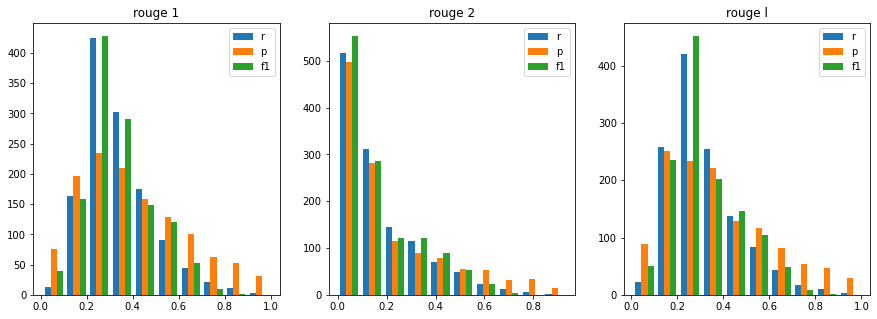

In [123]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].hist([list(df_tmp.iloc(1)[0]), list(df_tmp.iloc(1)[1]), list(df_tmp.iloc(1)[2])], label=['r', 'p', 'f1']);
axs[0].legend()
axs[0].set_title('rouge 1')
axs[1].hist([list(df_tmp.iloc(1)[3]), list(df_tmp.iloc(1)[4]), list(df_tmp.iloc(1)[5])], label=['r', 'p', 'f1']);
axs[1].legend()
axs[1].set_title('rouge 2')
axs[2].hist([list(df_tmp.iloc(1)[6]), list(df_tmp.iloc(1)[7]), list(df_tmp.iloc(1)[8])], label=['r', 'p', 'f1']);
axs[2].legend()
axs[2].set_title('rouge l')

In [25]:
best_rouge_calc_mean_1 = calc_rouge_mean(name_of_files_calc_1, list_of_files_calc_1)
best_rouge_calc_mean_2 = calc_rouge_mean(name_of_files_calc_2, list_of_files_calc_2)

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/363 [00:00<?, ?it/s]

In [11]:
val_res_dir = r"C:\Users\RedmiBook\Documents\SCE\proj\datasets\calculated\baseline\txt_best"
val_gold_dir = r"C:\Users\RedmiBook\Documents\SCE\proj\datasets\fns2020_dataset_clean\validation\gold_summaries"
val_top_dir = r"C:\Users\RedmiBook\Documents\SCE\proj\datasets\top1000-summaries"
val_muse_dir = r"C:\Users\RedmiBook\Documents\SCE\proj\datasets\validation-muse-1000"

In [12]:
name_of_files_1000, list_of_files_1000 = read_files(val_top_dir)
name_of_files_muse, list_of_files_muse = read_files(val_muse_dir)
name_of_files_gold, list_of_files_gold = read_files(val_gold_dir)
name_of_files_calc, list_of_files_calc = read_files(val_res_dir)   

In [13]:
def calc_rouge_mean(name_of_files, name_of_files_gold, list_of_files, list_of_files_gold, suf=4, cut=True):
    j = 0
    df_scores = pd.DataFrame(columns = ["rouge-1, r", "rouge-1, p", "rouge-1, f", 
                                        "rouge-2, r", "rouge-2, p", "rouge-2, f", 
                                        "rouge-l, r", "rouge-l, p", "rouge-l, f"])

    for i in tqdm(range(len(name_of_files)), total=len(name_of_files)):
        scores = []

        while j < len(name_of_files_gold) and name_of_files_gold[j][:-6] != name_of_files[i][:-suf]:
            j += 1
        while j < len(name_of_files_gold) and name_of_files_gold[j][:-6] == name_of_files[i][:-suf]:
            if cut == True:
                list_of_files[i] = ' '.join(list_of_files[i].split(' ')[:1000])            
            scores.append(rouge.get_scores(list_of_files[i], list_of_files_gold[j])[0])
            j += 1
#         print(scores)
        if scores != []:
            res_arr = np.zeros((len(scores), 9))
            for i in range(len(scores)):
                lst_i = list(scores[i].items())
                
                res_arr[i] = [list(lst_i[0][1].items())[0][1],
                              list(lst_i[0][1].items())[1][1],
                              list(lst_i[0][1].items())[2][1], 
                              list(lst_i[1][1].items())[0][1],
                              list(lst_i[1][1].items())[1][1],
                              list(lst_i[1][1].items())[2][1],
                              list(lst_i[2][1].items())[0][1],
                              list(lst_i[2][1].items())[1][1],
                              list(lst_i[2][1].items())[2][1]]
#                 print(res_arr[i])
            df_scores.loc[len(df_scores)] = res_arr.mean(axis=0)
        
    return df_scores

In [14]:
best_rouge_1000_mean = calc_rouge_mean(name_of_files_1000, name_of_files_gold, list_of_files_1000, list_of_files_gold, suf=9)
best_rouge_muse_mean = calc_rouge_mean(name_of_files_muse, name_of_files_gold, list_of_files_muse, list_of_files_gold, suf=9)

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

In [21]:
best_rouge_calc_mean_best = calc_rouge_mean(name_of_files_calc_best, name_of_files_gold, list_of_files_calc_best, list_of_files_gold)

  0%|          | 0/363 [00:00<?, ?it/s]

In [24]:
names = [
    np.array(["rouge1", "rouge1", "rouge1", "rouge2", "rouge2", "rouge2", "rougel", "rougel", "rougel"]),
    np.array(["r", "p", "f1", "r", "p", "f1", "r", "p", "f1"]),
    ]

In [25]:
df_rouge = pd.DataFrame([list(best_rouge_calc_mean_best.mean()), list(best_rouge_1000_mean.mean()), list(best_rouge_muse_mean.mean())], 
                        index=['calc', 'top-1000', 'muse'], columns=names)
df_rouge.transpose()

calc  top-1000      muse
rouge1 r   0.378317  0.534894  0.456453
       p   0.384531  0.374408  0.408530
       f1  0.343951  0.399157  0.391644
rouge2 r   0.199069  0.398208  0.288377
       p   0.199990  0.225484  0.248800
       f1  0.172410  0.255004  0.234891
rougel r   0.356737  0.516190  0.436119
       p   0.360554  0.354901  0.388336
       f1  0.323106  0.381251  0.373106